In [1]:
import numpy as np
import matplotlib.pyplot as plt
import prop
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.integrate import ode, simpson

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Perараметры текста
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

# 1. Исходные данные

In [2]:
t = 0.63 #время работы, с  
p = 13e6 # полное давление в камере, Па
J_eff = 9 # Эффективный импульс, Нс 
# Топливо
propel = prop.get_propellant('T-3')

p_atm = 1e5
T_min = 273-50
T_max = 273+50
T_N = 273+18

['P-1', '1600', '1030000', '360', '2860', '1.2', '2150', '400', '0', '0\n']
['P-2', '1620', '1040000', '349', '2980', '1.24', '2250', '278', '0', '0\n']
['P-3', '1650', '1040000', '359', '2900', '1.25', '2200', '400', '0', '0\n']
['B-1', '1610', '920000', '347', '2655', '1.24', '2200', '280', '0', '0\n']
['B-2', '1620', '1035000', '345', '3000', '1.23', '2250', '310', '0', '0\n']
['B-3', '1640', '1040000', '338', '3080', '1.25', '2300', '370', '0', '0\n']
['C-1', '1780', '1020000', '298', '3420', '1.17', '2600', '320', '0', '0\n']
['T-1', '1590', '0', '370.5', '2035', '1.26', '1979.6', '320', '8.58', '-0.151\n']
['T-2', '1650', '0', '321.4', '2600', '1.246', '2234.4', '320', '7.58', '0.0768\n']
['T-3', '1590', '0', '367.6', '2047', '1.24', '1979.6', '320', '6.45', '-0.095\n']


# 2. Расчётные формулы

In [3]:
R = J_eff/t  # реактивная сила, Н
G_t = R/propel.I_ud  # расход топлива, кг/с
omega = G_t*t  # масса топлива, кг
u = propel.u_1*1e-3*(p*1e-6)**propel.nu  # скорость горения (мм/с)
S = G_t/(u*propel.rho)   # площадь поверхности горения, м2
def A(k):
    return np.sqrt(k * (2 / (k + 1))**((k+1) / (k - 1)))
A_1 = A(propel.k) # постоянная расхода
F_dr = G_t * np.sqrt(propel.R * propel.T0) / (A_1 * p) # площадь дроссельного отверстия, м2
F_kr = F_dr
d_kr = np.sqrt(4 * F_dr / np.pi) # диаметр дроссельного отверстия, м
e_0 = u * t # толщина горящего свода, м
print("R =", R)
print("G_t =", G_t)
print("omega =", omega)
print("u =", u)
print("S =", S)
print("A_1 =", A_1)
print("F_dr =", F_dr)
print("d_kr =", d_kr)
print("e =", e_0)


R = 14.285714285714286
G_t = 0.007216465086741911
omega = 0.004546373004647404
u = 0.005055162214400369
S = 0.000897826240734676
A_1 = 0.6561856622944262
F_dr = 7.338395233978849e-07
d_kr = 0.0009666196256438164
e = 0.0031847521950722326


# 3. Рациональный вариант

In [4]:
m = 1 # т.к. количесвто шашек
D_N = 18.5e-3
print("D_N, мм =", D_N*1e3)
D_V=(D_N-4*e_0)
print("D_V, мм =", D_V*1e3)
L_z = 11e-3
print("L_z, мм =", L_z*1e3)

D_N, мм = 18.5
D_V, мм = 5.760991219711069
L_z, мм = 11.0


# 4. Расчёт формы заряда

S_sr = 0.0008383996696311583
S_g = 0.000897826240734676


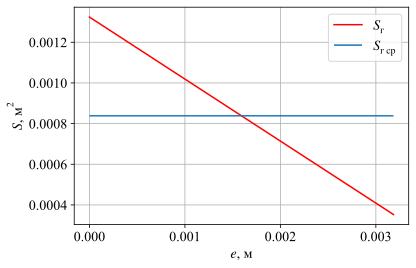

In [5]:
def S_zar(e):
    return (np.pi * (D_V + 2*e)*(L_z - 2*e) + np.pi * (D_N - 2*e) * (L_z - 2*e) + \
        np.pi * 0.5 * (((D_N - 2*e) ** 2) - ((D_V + 2*e) ** 2)))

e = np.linspace(0, e_0, 100)
s = np.array([S_zar(ex) for ex in e])
plt.plot(e, s, color='red', label='$\mathit{S}_{\mathrm{г}}$')
plt.hlines(s.mean(), xmin=0, xmax=e_0,
           label='$\mathit{S}_{\mathrm{г\;ср}}$')
plt.legend()
plt.xlabel('$\mathit{e}$, м')
plt.ylabel('$\mathit{S}$, $м^2$')
plt.grid()                                                                                                          
S_sr = s.mean()
print("S_sr =", S_sr)
print("S_g =", S)

# 4. Расчёт воспламенителя

In [6]:
class Vosplamenitel:
    def __init__(self, F_kr, F_oxl, W_0, e_0 = 0.6e-2, m = 3) -> None:
        self.R = 314
        self.Q = 3050e3
        self.u = 0.05
        self.k = 1.25
        self.rho = 1700
        self.m = m

        self.t_v = e_0 / self.u
        self.T_v = ((self.k - 1) / self.k) * (self.Q / self.R)
        
        self.p_vsp_50 = self.p_vsp(T_min)
        self.p_max = 1.1 * self.p_vsp_50

        b21 = (self.k - 1) / W_0  *  (propel.nu_t * propel.sigma_t * F_oxl) / self.R
        b22 = self.k / W_0 * A(self.k) * F_kr * np.sqrt(self.R * self.T_v)
        self.b2 = b21 + b22
        
        S0_v1 = self.p_max * self.b2 * ((self.m / (self.t_v * self.b2)) ** (-self.m / (self.t_v * self.b2 - self.m)))
        S0_v2 = (self.k - 1) * self.u * self.rho * self.Q
        self.S0_v = S0_v1 / S0_v2 * W_0
        self.b1 = ((self.k-1) / W_0) * self.rho * self.S0_v * self.u * self.Q

        self.omega = e_0 * self.rho * self.S0_v * ((1 - np.exp(- self.m)) / self.m)
        print(self.omega)
        self.__t_vs = np.linspace(0,0.2,2000)
        self.__p_vs = np.array([self.p_v(t) for t in self.__t_vs])

        self.t_vsp = self.__t_vs[self.__p_vs >= self.p_vsp_50][0]

    def p_vsp(self,T_n):
        """Давление вспышки в зависимости от начальной температуры

        Args:
            T_n (float): начальная температура, К

        Returns:
            p_vsp: давление вспышки, Па
        """
        return propel.c_t * propel.rho / propel.sigma_t * propel.u(1e6, T_n) * self.R * self.T_v * (propel.T_s - T_n) / (self.T_v - propel.T_s)

    def p_v(self,t):
        """Зависимость давления от времени при автономном горения воспламенителя

        Args:
            t (float): время, с

        Returns:
            p: давление, Па
        """
        p1 = p_atm + self.b1 / ((self.m / self.t_v) - self.b2)
        p2 = self.b1 / ((self.m / self.t_v) - self.b2)
        return p1 * np.exp(- self.b2 * t) - p2 * np.exp(- self.m * t / self.t_v)

    def S(self,t):
        """Закон горения воспламенителя

        Args:
            t (float): время, с

        Returns:
            S: площадь горения, м2
        """
        return self.S0_v * np.exp(-self.m * t / self.t_v)

    def get_results(self, figure_filename = 'График p_vospl.svg'):
        """Получение результатов расчета воспламенителя

        Args:
            figure_filename (str, optional): название картинки. Defaults to 'График p_vospl.svg'.
        """
        print(f'Температура продуктов сгорания воспламенителя Tв = {self.T_v:.0f} К\n',
              f'Давление вспышки основного заряда при T_min p_vsp(T_min) = {self.p_vsp_50/1e6:.3f} МПа\n',
              f'Максимальное давление воспламенителя p_max = {self.p_max/1e6:.3f} МПа\n',
              f'Начальная площадь поверхности горения S0в = {self.S0_v:.5f} м2\n',
              f'Масса навески воспламенителя omega_в = {self.omega} г\n',
              f'Время воспламенения основного заряда t_v = {self.t_vsp*1e3:.1f} мс')

        plt.figure(figsize=(9, 6))
        plt.plot(self.__t_vs[self.__p_vs >= p_atm], self.__p_vs[self.__p_vs >= p_atm]/1e6)
        plt.axhline(self.p_vsp_50/1e6, linestyle = '--', color = 'tab:red', label = '$\mathit{p}_{всп}$ = '+f'{self.p_vsp_50/1e6:.3f} МПа')

        plt.legend(loc = 'upper right')
        plt.grid()
        plt.xlabel('$\mathit{t}, с$')
        plt.ylabel('$\mathit{p}, МПа$')
        if figure_filename:
            plt.savefig(figure_filename, dpi=300, bbox_inches='tight')

        plt.show()

Начальный свободный объем W0 = 0.190 * 10^5 м3
 Площадь, омываемая ПС F_oxl = 0.0008 м2
0.00020771860131450588
Температура продуктов сгорания воспламенителя Tв = 1943 К
 Давление вспышки основного заряда при T_min p_vsp(T_min) = 5.046 МПа
 Максимальное давление воспламенителя p_max = 5.550 МПа
 Начальная площадь поверхности горения S0в = 0.00006 м2
 Масса навески воспламенителя omega_в = 0.00020771860131450588 г
 Время воспламенения основного заряда t_v = 4.9 мс


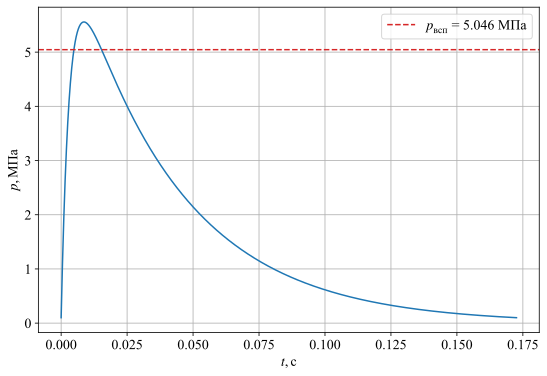

0.12

In [7]:
W_0 = np.pi / 4 * (23e-3)**2 * L_z- np.pi/4 * (D_N**2 - D_V**2)*L_z     
F_oxl = 23e-3*np.pi*L_z
print(f'Начальный свободный объем W0 = {W_0 * 1e5:.3f} * 10^5 м3\n',
      f'Площадь, омываемая ПС F_oxl = {F_oxl:.4f} м2')

vospl = Vosplamenitel(F_kr,F_oxl,W_0)
vospl.get_results()
vospl.t_v

#### ОЗВБ

In [8]:
pi = lambda lmbd, k: (1 - (k - 1)/(k + 1)*lmbd**2) ** (k / (k - 1))
mu_c = 0.95
e_max = e_0
Q_t = propel.k / (propel.k - 1) * propel.R * propel.T0
print("Q_t =", Q_t)

Q_t = 3887798.866666667


In [9]:
def sys_int(t, Y, T0, p_vsp):
    
    p, W, e_t = Y
    U = np.zeros(3)

    Hev_v = 1 if t <= vospl.t_v else 0
    Hev_p = 1 if p > p_vsp or abs(e_t) > 0 else 0
    Hev_e = 1 if 0 <= abs(e_t) <= e_max else 0

    u_g = propel.u(p,T0)
    S_g = S_zar(abs(e_t))

    #domega_v/dt
    G_v = vospl.S(t) * vospl.u * vospl.rho*np.exp(-vospl.m*t/vospl.t_v) * Hev_v

    #dp/dt
    p1 = (propel.k - 1) * vospl.Q / (propel.rho * S_g * u_g) * G_v + (propel.k - 1) * Q_t * Hev_e
    p2 = propel.k * (mu_c * A(propel.k) * F_kr * p / (propel.rho * S_g * u_g)) ** 2
    p3 = (propel.k - 1) * propel.sigma_t * propel.nu_t * F_oxl * p / (propel.R * propel.rho * S_g * u_g)
    p4 = propel.k * p / (vospl.rho * propel.rho * S_g * u_g) * G_v
    p5 = propel.k * p / propel.rho * Hev_e
    U[0] = (p1 - p2 - p3 - p4 - p5) * propel.rho * S_g * u_g / W

    #de/dt
    U[2] = u_g * Hev_p * Hev_e

    #domega_t/dt
    G_t = S_g * propel.rho * U[2]

    #dW/dt
    U[1] = 1 / propel.rho * G_t + 1 / vospl.rho * G_v

    return U

def res_int(T0):

    stop = lambda p: p * pi(1,propel.k) <= p_atm
    # stop = lambda p: p <= p_atm

    Y_0 = [0, p_atm, W_0, 0]

    result = dict()
    keys = ['t','p','W','e_t']
    for key, val in zip(keys,Y_0):
        result[key] = np.array([val])

    r = ode(sys_int).set_integrator('vode', method = 'adams')     #'vode', method = 'adams'
    r.set_initial_value(Y_0[1:])
    r.set_f_params(T0, vospl.p_vsp(T0))

    while r.successful() and (not stop(result['p'][-1]) or result['t'][-1] < 0.005):
        dt = 5e-6
        result['t'] = np.append(result['t'], result['t'][-1] + dt)
        Y_tek = r.integrate(r.t+dt)
        for key, val in zip(keys[1:],Y_tek):
            result[key] = np.append(result[key], val)

    result['T_n'] = T0

    return result

In [10]:
res18 = res_int(T_N)
# res50 = res_int(T_max)
# res_50 = res_int(T_min)

10.407805940152118


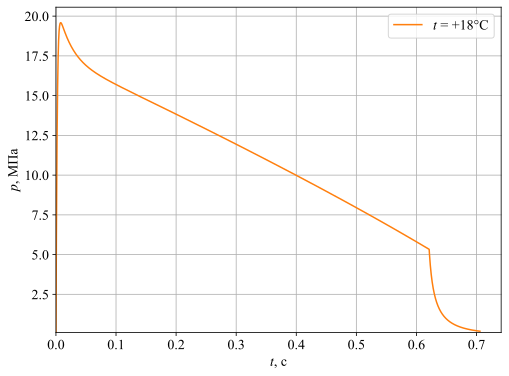

In [11]:
plt.figure(figsize = (8,6))
plt.plot(res18['t'], res18['p']/1e6, c = 'tab:orange', label = '$\mathit{t}$ = +18°C')
# plt.axhline(p1_max/1e6,ls = '--',c = 'tab:red')
# plt.axhline(4.5e6/1e6,ls = '--',c = 'tab:blue')
# plt.axhline(p1N/1e6,ls = '--',c = 'tab:green')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1_min /1e6 + 3,'$\mathit{p}_{min}$')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1N /1e6 + 3,'$\mathit{p}_{N}$')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1_max /1e6 + 3,'$\mathit{p}_{max}$')
# plt.plot(0.7/0.4*res50['t'],0.95*res50['p']/1e6, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
# plt.plot(0.7/0.4*res_50['t'],0.95*res_50['p']/1e6, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')
# plt.axvline(t_g + vospl.t_vsp,ls = '--',c = 'grey', label = '$\mathit{t}_{в}$ + $\mathit{t}_г$')
print(sum(res18['p'])/len(res18['p'])*1e-6)
plt.xlim(0)
plt.ylim(0.1)
# plt.ylim(top = 18.5)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{p}$, МПа')
plt.legend(loc = 'upper right')
plt.grid()
plt.savefig('Инд p.svg', dpi=500, bbox_inches='tight')
plt.show()

10.407805940152118


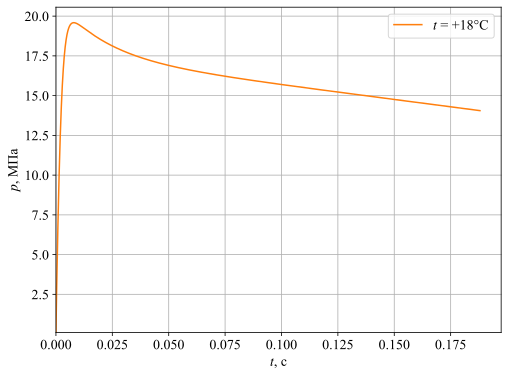

In [12]:
plt.figure(figsize = (8,6))
plt.plot(res18['t'][res18['t'] <= 0.188], res18['p'][res18['t'] <= 0.188]/1e6, c = 'tab:orange', label = '$\mathit{t}$ = +18°C')
# plt.axhline(p1_max/1e6,ls = '--',c = 'tab:red')
# plt.axhline(4.5e6/1e6,ls = '--',c = 'tab:blue')
# plt.axhline(p1N/1e6,ls = '--',c = 'tab:green')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1_min /1e6 + 3,'$\mathit{p}_{min}$')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1N /1e6 + 3,'$\mathit{p}_{N}$')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1_max /1e6 + 3,'$\mathit{p}_{max}$')
# plt.plot(0.7/0.4*res50['t'],0.95*res50['p']/1e6, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
# plt.plot(0.7/0.4*res_50['t'],0.95*res_50['p']/1e6, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')
# plt.axvline(t_g + vospl.t_vsp,ls = '--',c = 'grey', label = '$\mathit{t}_{в}$ + $\mathit{t}_г$')
print(sum(res18['p'])/len(res18['p'])*1e-6)
plt.xlim(0)
plt.ylim(0.1)
# plt.ylim(top = 18.5)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{p}$, МПа')
plt.legend(loc = 'upper right')
plt.grid()
plt.savefig('Инд p.svg', dpi=500, bbox_inches='tight')
plt.show()